In [15]:
import math 
import numpy as np
import pandas as pd
import sympy
from matplotlib import pyplot as plt
from tabulate import tabulate

In [16]:
def plot_fun(f, a, b, label="", color="r", step=0.01, ax=plt, title="Wykres funkcji"):
    n = int((b-a)/step)+1
    x = np.linspace(a,b,n)[1:]
    ax.plot(x, [f(xi) for xi in x], color=color, label=label)
    if label:
        ax.legend(loc="best")

    if ax is plt:
        ax.title(title)
        ax.xlabel("x")
        ax.ylabel("y")
    else:
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    ax.grid()

def abs_diff(f, W, x):
    return [abs(f(xi)-float(W(xi))) for xi in x[1:]]

def max_diff(f, W, x):
    return max(abs_diff(f, W, x[1:]))

def mean_square_error(f, W, x):
    return sum(d ** 2 for d in abs_diff(f, W, x[1:]))

def error(f, W, label, a, b, n, N=1000):
    x = np.linspace(a,b,n)
    diffs = []
    if isinstance(W, list):
        for i, w in enumerate(W):
            diffs += (abs_diff(f,w,np.linspace(x[i],x[i+1],N)))
    else:
        x = np.linspace(a,b,N)
        diffs = abs_diff(f,W,x)
        
    print(tabulate([
        ("Błąd bezwzględny:", max(diffs)),
        ("Suma kwadratów róznic:", sum(xi**2 for xi in diffs))
    ], [
        f"Interpolacja {label}"
    ], tablefmt="fancy_grid", floatfmt=f'.{6}f'))

In [17]:
def czebyszew_node(a, b, n):
    return [0.5*(a+b)+0.5*(b-a)*math.cos((2*i - 1)/(2*n)*math.pi) for i in range(n, 0, -1)]

In [18]:
x = sympy.Symbol('x')
fs = sympy.exp(-4*sympy.sin(2*x)) + 4*sympy.cos(2*x) 
fs1 = fs.diff(x)
fs2 = fs1.diff(x)
fs3 = fs2.diff(x)

f1 = sympy.lambdify(x, fs1)
f2 = sympy.lambdify(x, fs2)
f3 = sympy.lambdify(x, fs3)


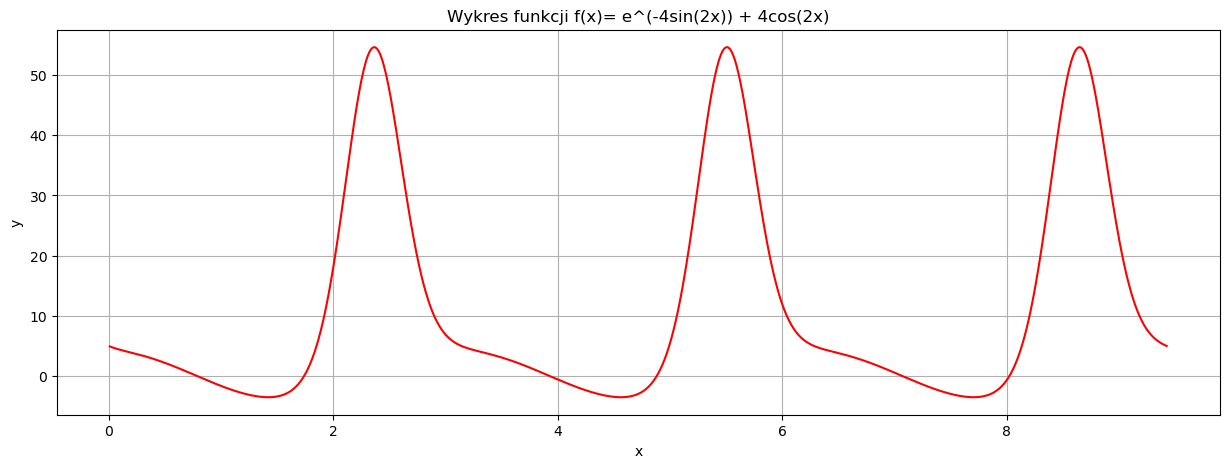

In [19]:
f = lambda x, k, m: math.e**(-k*math.sin(m*x)) + k*math.cos(m*x) 

g = lambda x: f(x, 4, 2)
a = 0
b = 3*math.pi
plt.figure(figsize=(15,5))
plot_fun(g, a, b, title="Wykres funkcji f(x)= e^(-4sin(2x)) + 4cos(2x)") 
plt.show()

In [32]:
"""
a = y[:-1]
    b = (y[1:]-y[:-1])/h - h*(m[:-1]+2*m[1:])
    c = 3*m[:]
    d = (m[1:]-m[:-1])/h
"""

def cubic_spline(x, y):
    n = len(x)-1
    h = np.diff(x)

    A = np.zeros((n+1, n+1))
    B = np.zeros(n+1)

    A[0,0] = 1
    A[-1,-1] = 1

    for i in range(1,n):
        A[i,i-1] = h[i-1]
        A[i,i] = 2*(h[i-1]+h[i])
        A[i, i+1] = h[i]
        B[i] = 3*((y[i+1]-y[i])/h[i]-(y[i]-y[i-1])/h[i-1])

    m = np.linalg.solve(A, B)

    a = y[:-1]
    b = (y[1:]-y[:-1])/h - h*(2*m[:-1]+m[1:])/6
    c = m[:-1]/2
    d = (m[1:]-m[:-1])/(6*h)

    def spline(t):
        i = np.searchsorted(x,t) - 1
        i = np.where(i==n, n-1, i)
        dx = t - x[i]
        return a[i]+b[i]*dx +c[i]*dx**2 + d[i]*dx**3
    
    return spline

def cubic_test(x, y):
    n = len(x)-1
    h = np.diff(x)
    delta = np.diff(y)/h

    A = np.zeros((n-1,n-1))
    np.fill_diagonal(A, 2*(h[:-1]+h[1:]))
    np.fill_diagonal(A[:-1,1:], h[1:-1])
    np.fill_diagonal(A[1:,:-1], h[1:-1])

    B = 3*(delta[1:]-delta[:-1])

    sigma = np.zeros(n+1)
    sigma[1:n] = np.linalg.solve(A, B)

    a = (sigma[1:] - sigma[:-1]) / (3*h)
    b = sigma[:-1]
    c = (delta/h) - h*(2*sigma[:-1]+sigma[1:])/3
    d = y[:-1]

    def spline(x0):
        i = np.searchsorted(x,x0) - 1
        i = np.where(i==n, n-1, i)
        dx = x0 - x[i]
        return a[i]*dx**3+b[i]*dx**2+c[i]*dx+d[i]
    
    return spline

def cubic_spline_clamped_boundary(x, y, dy0=f1(a), dyn=f1(b)):
    n = len(x)-1
    h = np.diff(x)

    A = np.zeros((n+1, n+1))
    B = np.zeros(n+1)

    A[0,0] = 2
    A[0,1] = 1
    B[0] = 0
    A[-1,-2] = 1
    A[-1,-1] = 2
    B[-1] = 0

    for i in range(1,n):
        A[i,i-1] = h[i-1]
        A[i,i] = 2*(h[i-1]+h[i])
        A[i, i+1] = h[i]
        B[i] = 3*((y[i+1]-y[i])/h[i]-(y[i]-y[i-1])/h[i-1])

    m = np.linalg.solve(A, B)

    a = y[:-1]
    b = (y[1:]-y[:-1])/h - h*(2*m[:-1]+m[1:])/6
    c = m[:-1]/2
    d = (m[1:]-m[:-1])/(6*h)

    def spline(t):
        i = np.searchsorted(x,t) - 1
        i = np.where(i==n, n-1, i)
        dx = t - x[i]
        return a[i]+b[i]*dx +c[i]*dx**2 + d[i]*dx**3
    
    return spline

def quad_spline(x,y):
    n = len(y)
    a_l = []
    b_l = [0]
    c_l = y
    fn = []

    def yy(i):
        return (y[i] - y[i-1])/(x[i]-x[i-1])
    
    for i in range(1, n):
        b_l.append(2*yy(i)-b_l[-1])

    for i in range(n-1):
        a_l.append((b_l[i+1]-b_l[i])/(2*(x[i+1]-x[i])))

    def calc_fun(a ,b, c, x):
        def s(i):
            return lambda x0: a[i]*(x0-x[i])**2 + b[i]*(x0-x[i]) + c[i]

        for i in range(n-1):
            fn.append(s(i))
    
    calc_fun(a_l, b_l, c_l, x)
    return fn

def quad_spline_clamped_boundary(x,y):
    n = len(y)
    a_l = []
    b_l = [(y[1]-y[0])/(x[1]-x[0])]
    c_l = y
    fn = []

    def yy(i):
        return (y[i] - y[i-1])/(x[i]-x[i-1])
    
    for i in range(1, n):
        b_l.append(2*yy(i)-b_l[-1])

    for i in range(n-1):
        a_l.append((b_l[i+1]-b_l[i])/(2*(x[i+1]-x[i])))

    def calc_fun(a ,b, c, x):
        def s(i):
            return lambda x0: a[i]*(x0-x[i])**2 + b[i]*(x0-x[i]) + c[i]

        for i in range(n-1):
            fn.append(s(i))
    
    calc_fun(a_l, b_l, c_l, x)
    return fn


In [21]:
def plot_interpolation(f, n,N=1000, title="", show_err=False, spline_fun=cubic_spline, label=""):
    x = np.linspace(a, b, n)
    y = np.array([f(xi) for xi in x])
    
    W = spline_fun(x, y)

    fig, ax = plt.subplots(1, figsize=(15,4))

    plot_fun(f, a, b, step=0.01, color="black", label="f(x)= e^(-4sin(2x)) + 4cos(2x)", ax=ax)
    if isinstance(W, list):
        for i, fn in enumerate(W):
            plot_fun(fn, x[i], x[i+1], label=label, color="red", ax=ax, title=title)
    else:
        plot_fun(W, a, b, step=0.01, label=label, color="red", ax=ax, title=title)
    ax.scatter(x, y, color="green")

    if show_err:
        error(f,W,"Sklejana",a,b,n=n,N=N)

    plt.show()

In [22]:
#plot_interpolation(g, 10)

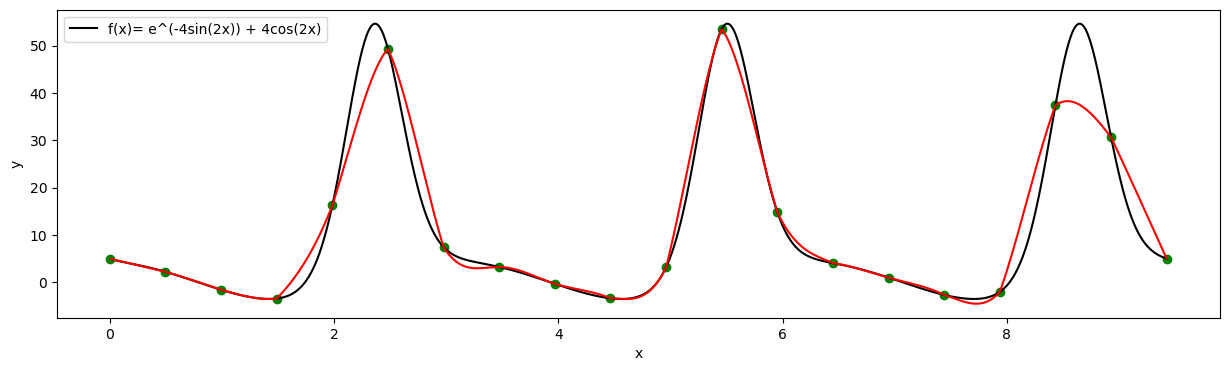

In [36]:
plot_interpolation(g, 20, spline_fun=cubic_spline_clamped_boundary)

In [ ]:
#plot_interpolation(g, 4, spline_fun=quad_spline)

In [ ]:
#plot_interpolation(g, 4, spline_fun=quad_spline_clamped_boundary)

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               59.651646 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           919149.602888 │
╘════════════════════════╧═════════════════════════╛


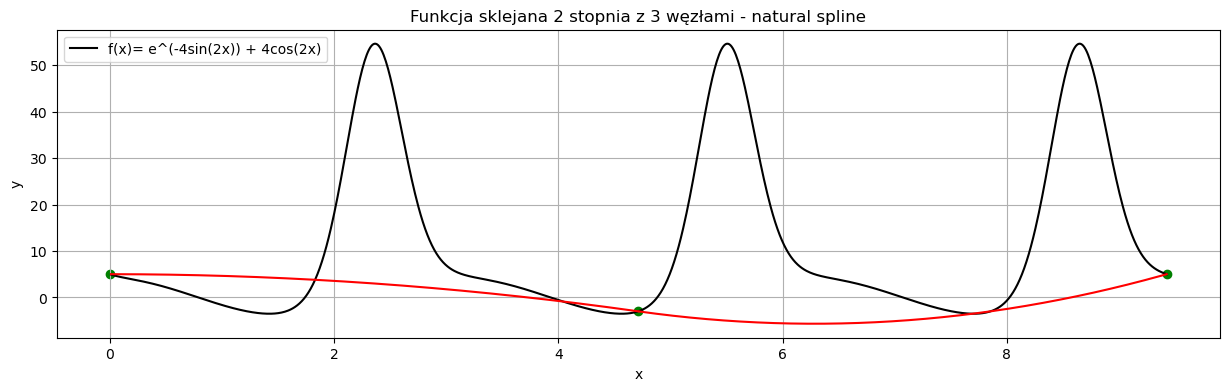

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               58.527239 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           903417.579154 │
╘════════════════════════╧═════════════════════════╛


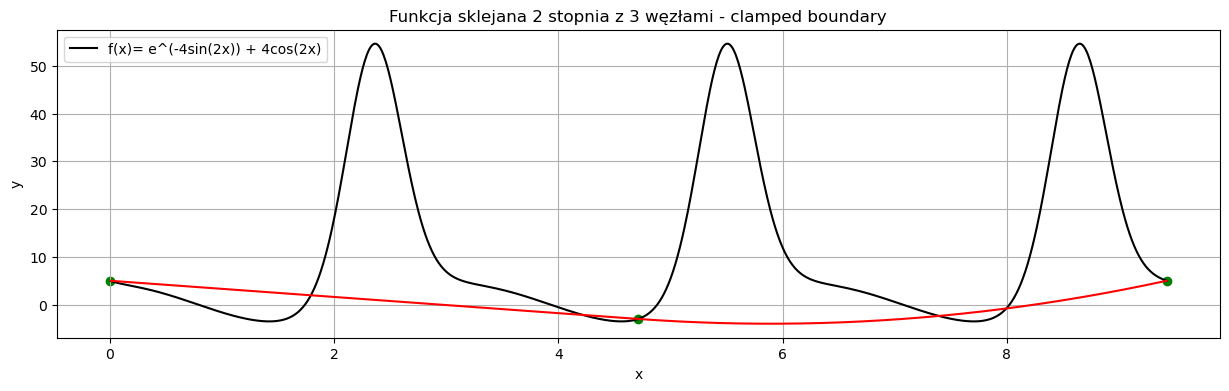

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               56.793073 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           428863.447968 │
╘════════════════════════╧═════════════════════════╛


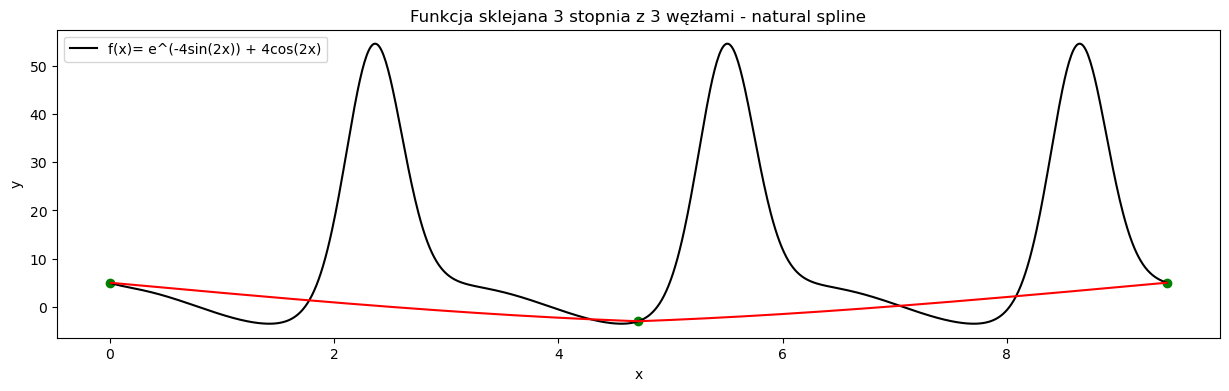

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              104.548668 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          2560547.556381 │
╘════════════════════════╧═════════════════════════╛


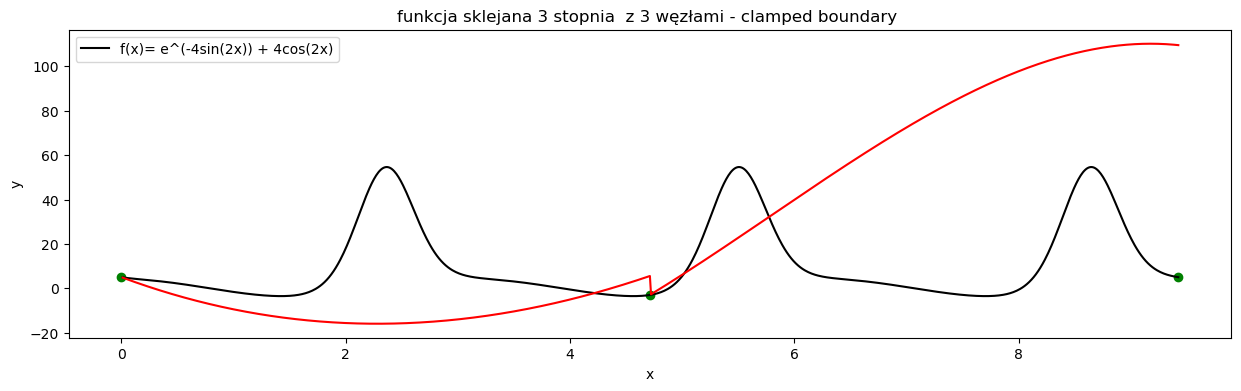

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              105.647583 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          7406538.262555 │
╘════════════════════════╧═════════════════════════╛


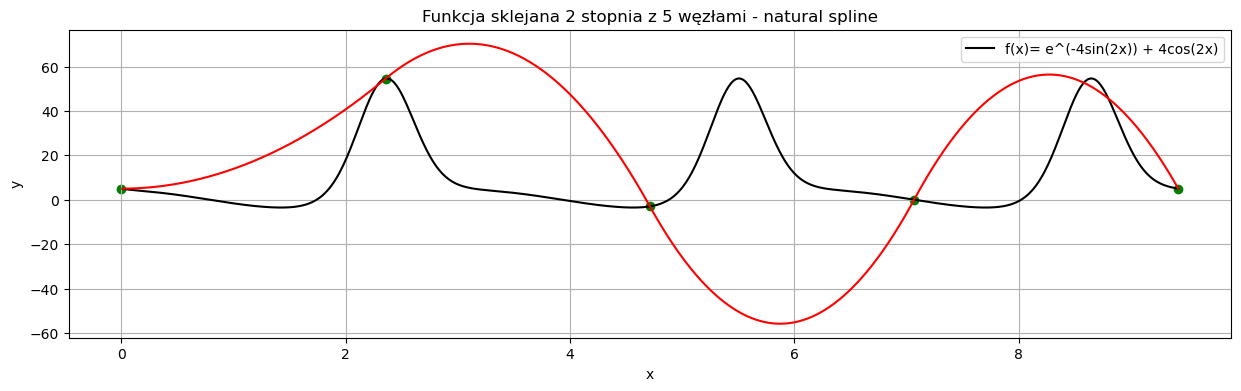

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               94.382405 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          5622609.499982 │
╘════════════════════════╧═════════════════════════╛


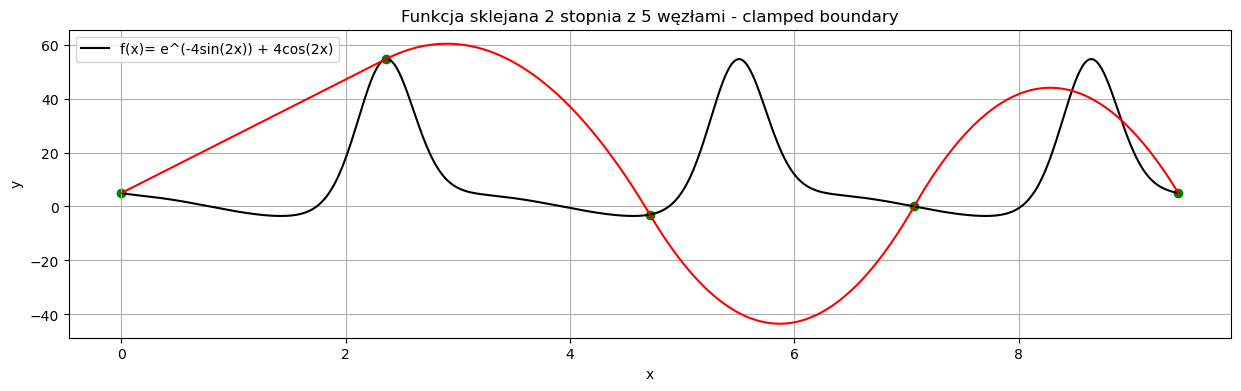

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               60.373263 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           665556.032394 │
╘════════════════════════╧═════════════════════════╛


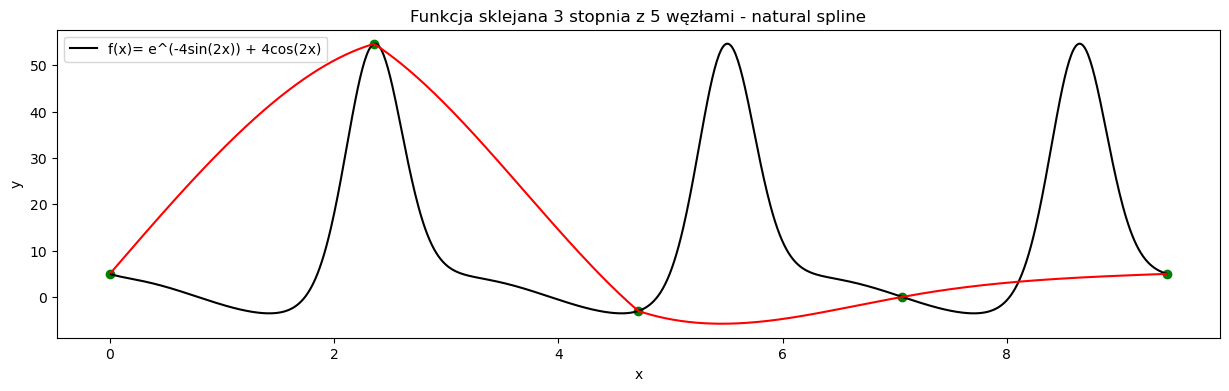

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              320.202719 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │         14545739.478070 │
╘════════════════════════╧═════════════════════════╛


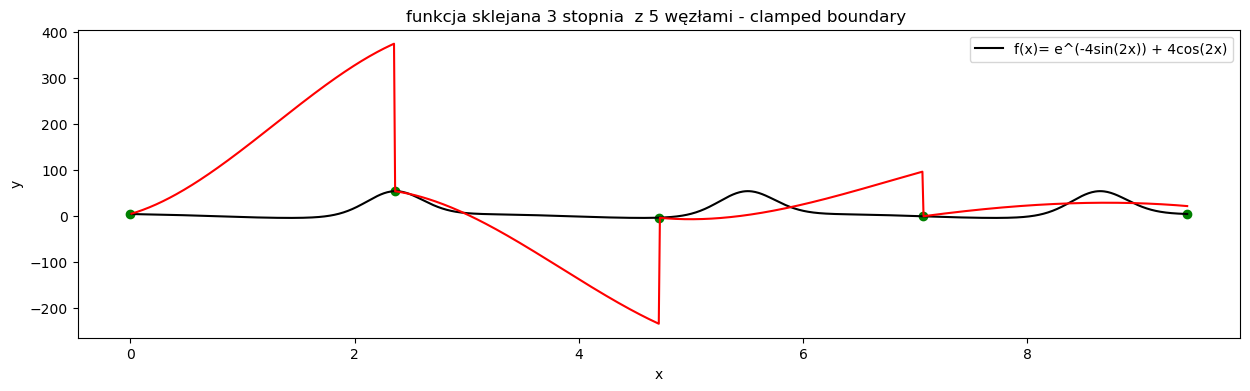

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               75.602378 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          4700008.012985 │
╘════════════════════════╧═════════════════════════╛


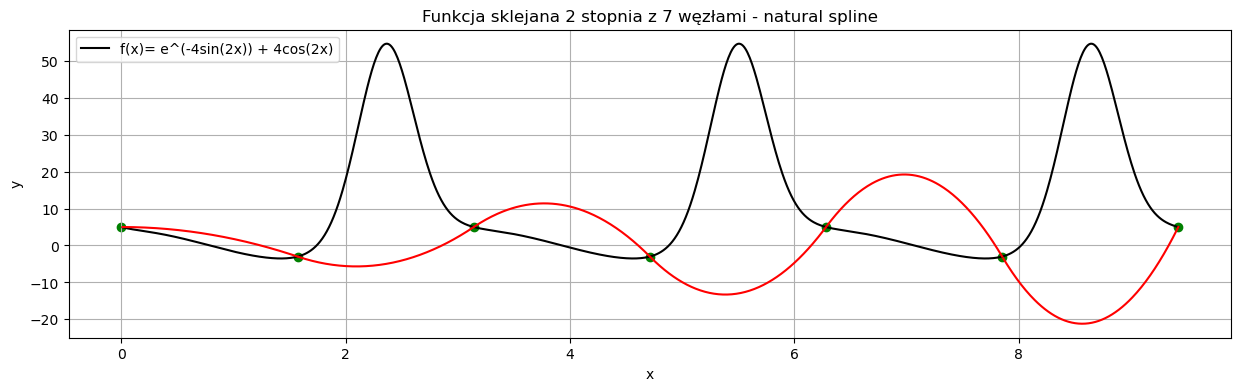

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               73.602396 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          4320818.090533 │
╘════════════════════════╧═════════════════════════╛


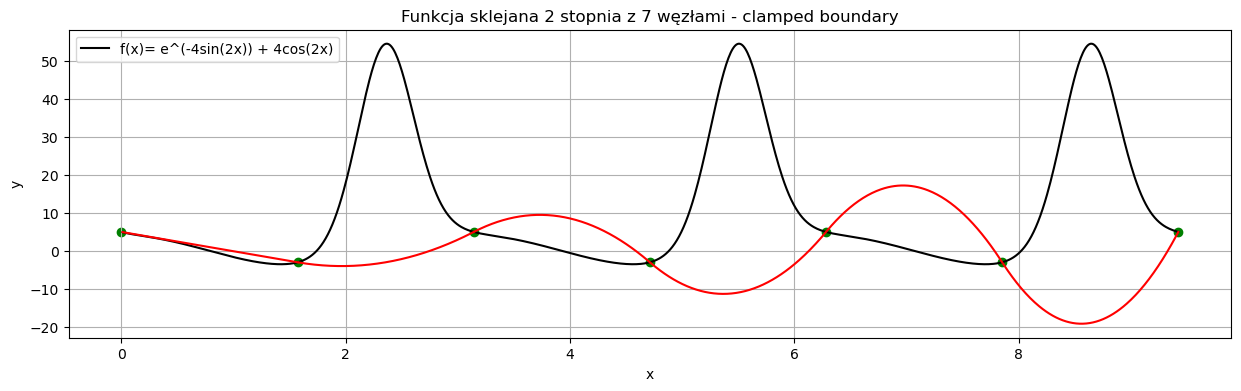

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               54.697623 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           411333.059112 │
╘════════════════════════╧═════════════════════════╛


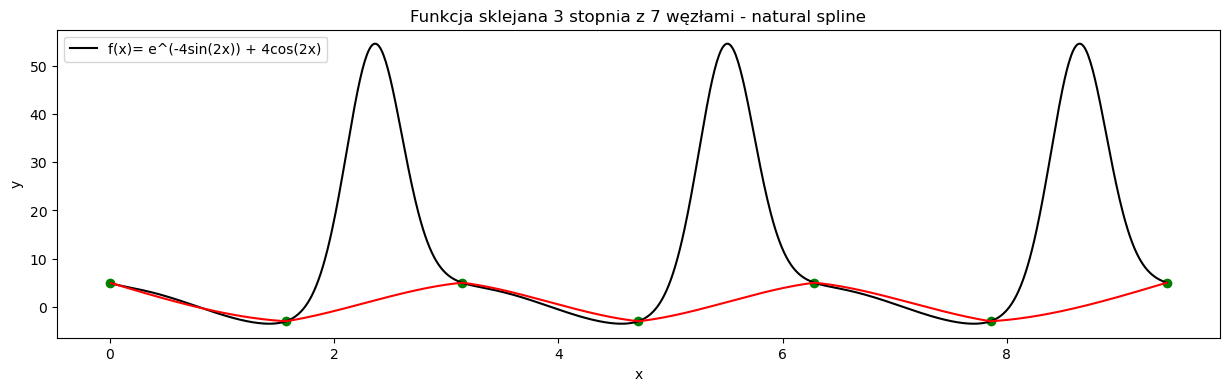

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               75.549351 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           729896.457883 │
╘════════════════════════╧═════════════════════════╛


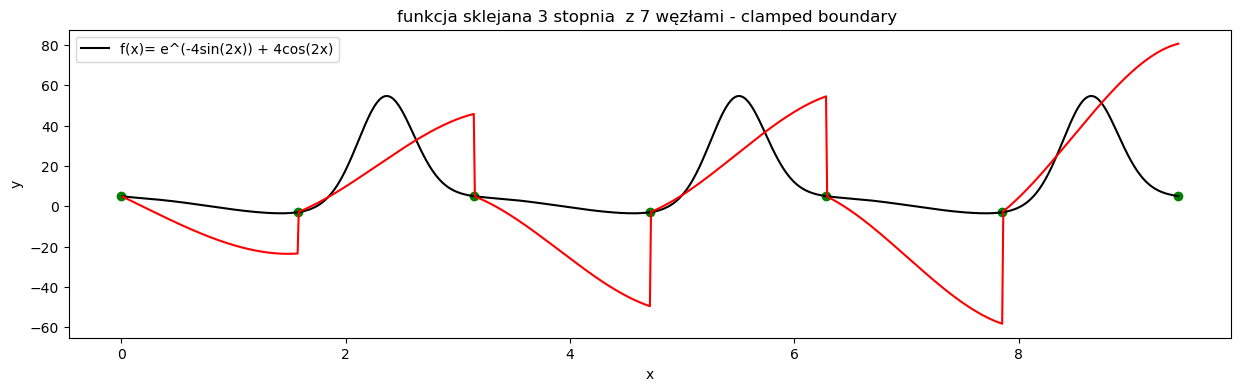

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               38.470544 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          2094313.339635 │
╘════════════════════════╧═════════════════════════╛


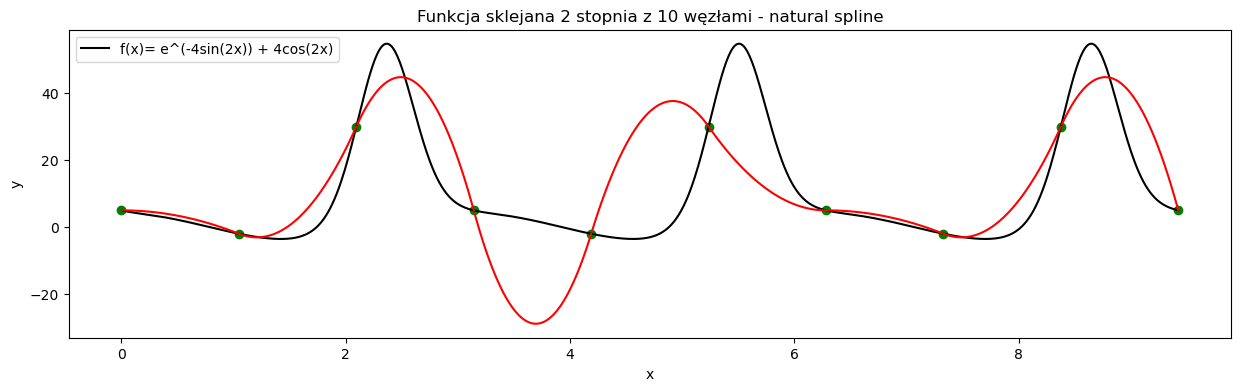

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               36.780194 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          1926791.373088 │
╘════════════════════════╧═════════════════════════╛


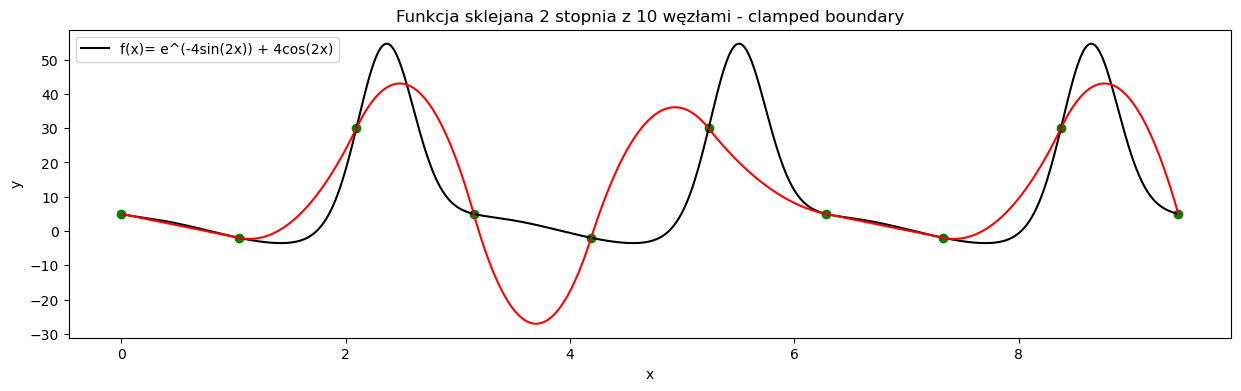

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               28.953711 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           150868.335682 │
╘════════════════════════╧═════════════════════════╛


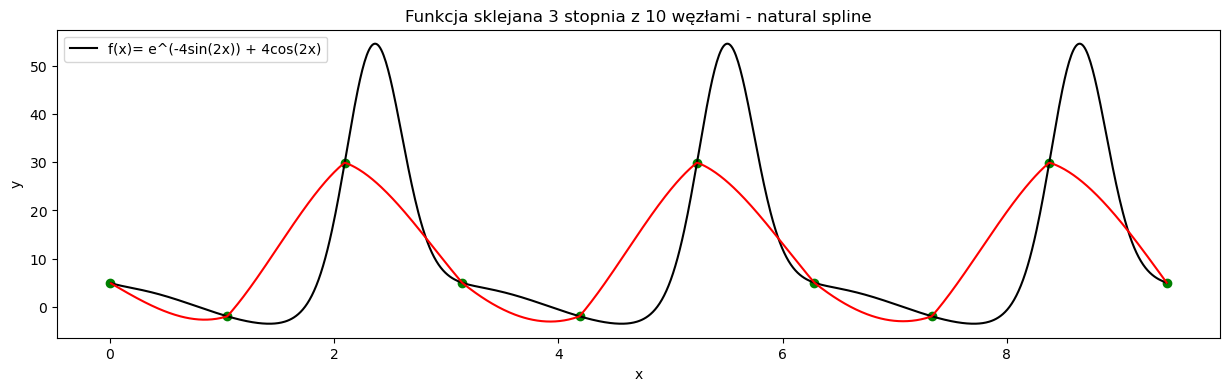

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              126.539911 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          3648539.924249 │
╘════════════════════════╧═════════════════════════╛


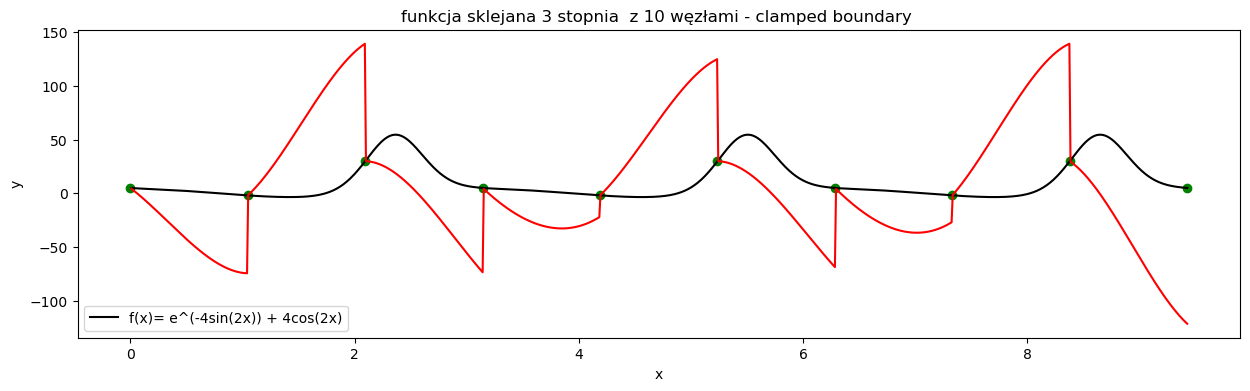

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               59.885499 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          5562419.423743 │
╘════════════════════════╧═════════════════════════╛


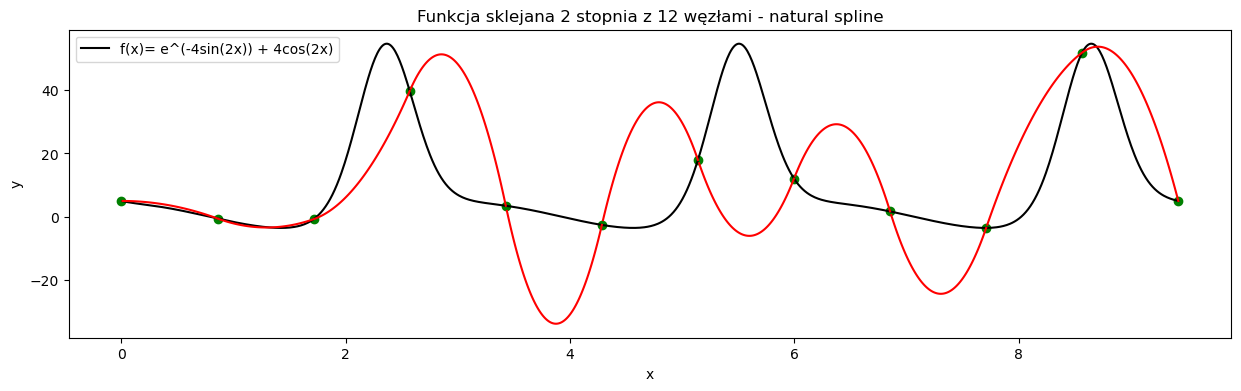

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               61.259315 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          5937231.024143 │
╘════════════════════════╧═════════════════════════╛


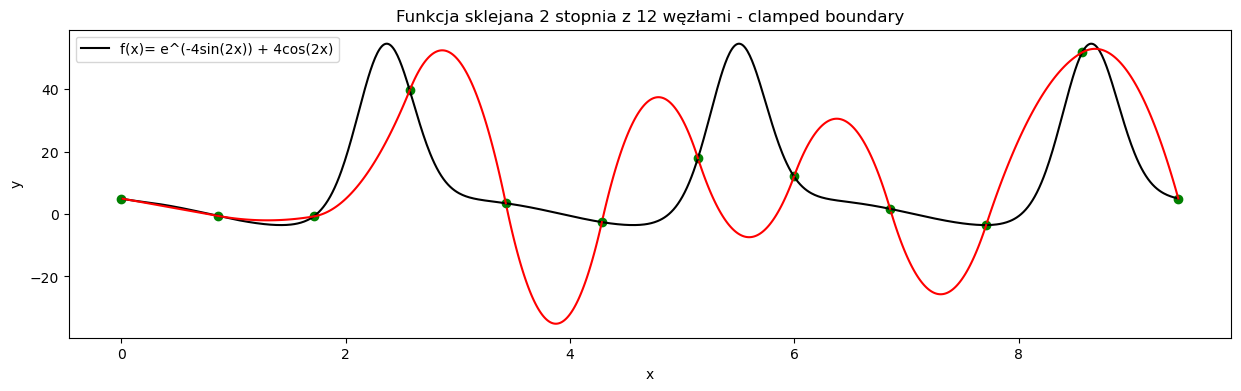

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               38.004269 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           118251.878272 │
╘════════════════════════╧═════════════════════════╛


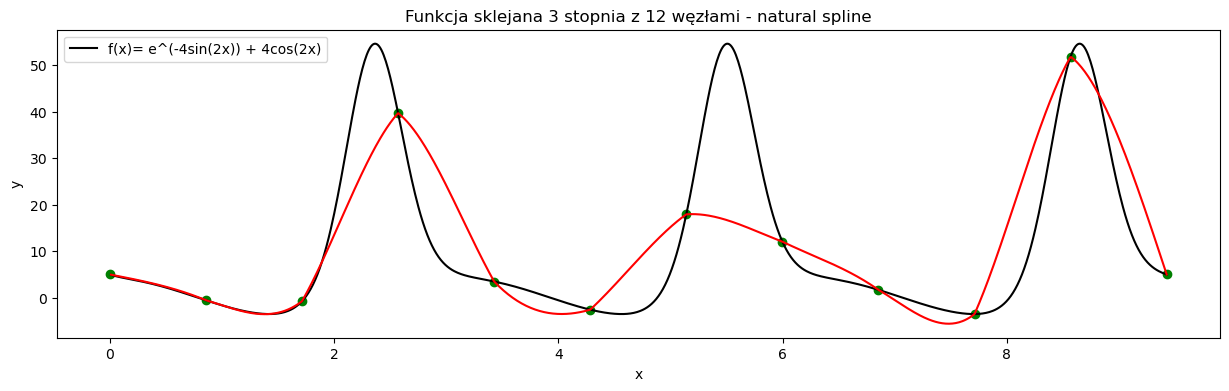

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              252.323557 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          5586668.270366 │
╘════════════════════════╧═════════════════════════╛


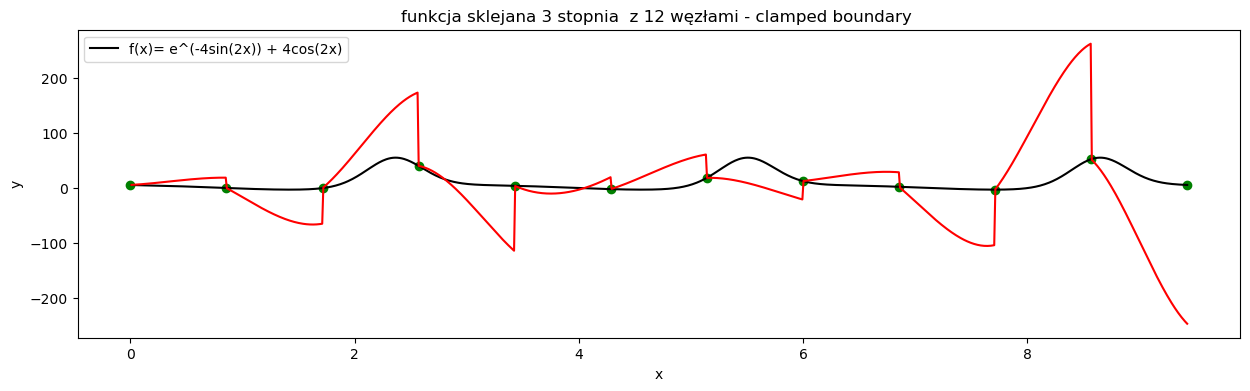

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              155.664131 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │         41839172.495666 │
╘════════════════════════╧═════════════════════════╛


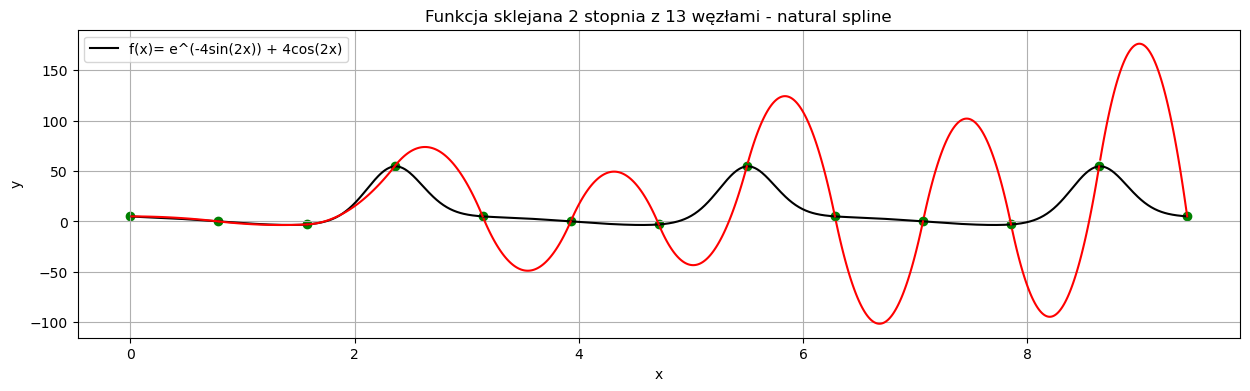

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              156.908353 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │         42888698.580727 │
╘════════════════════════╧═════════════════════════╛


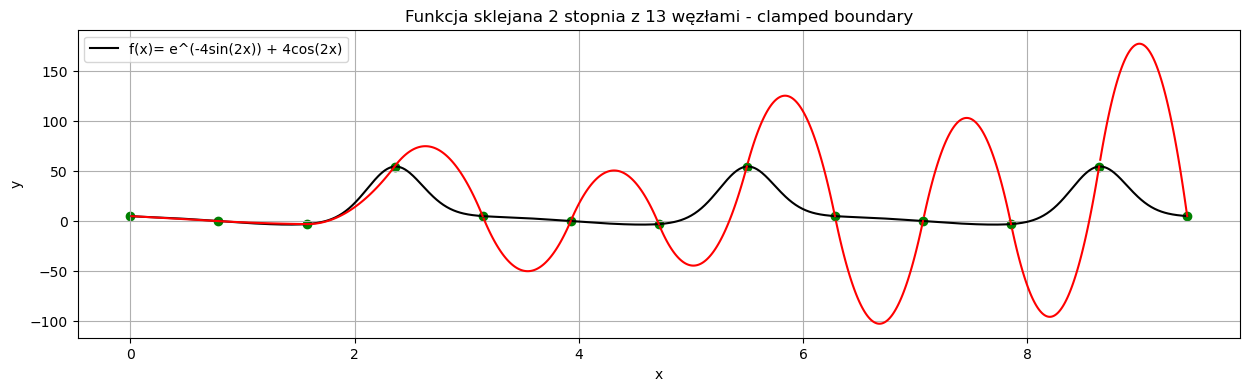

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               16.873478 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │            42569.551909 │
╘════════════════════════╧═════════════════════════╛


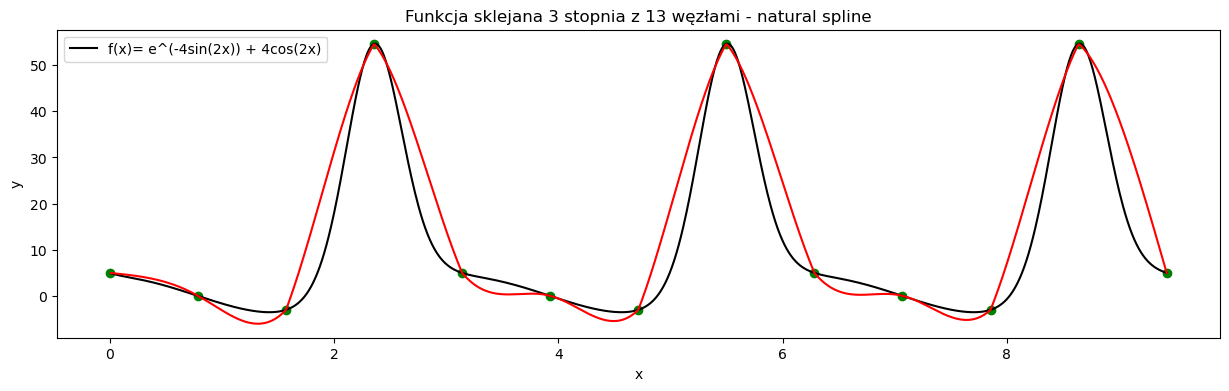

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              268.884618 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │         10575329.384244 │
╘════════════════════════╧═════════════════════════╛


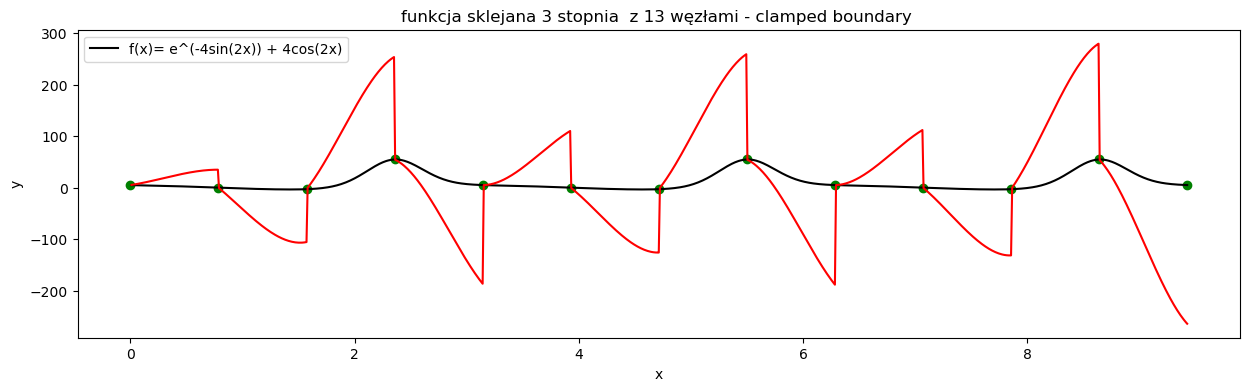

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               43.263888 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          3842904.742849 │
╘════════════════════════╧═════════════════════════╛


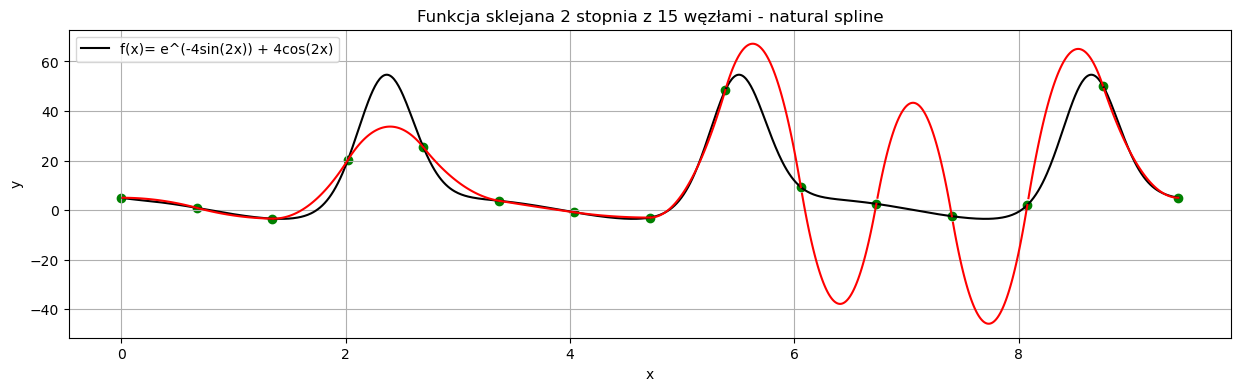

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               42.241480 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          3624587.342799 │
╘════════════════════════╧═════════════════════════╛


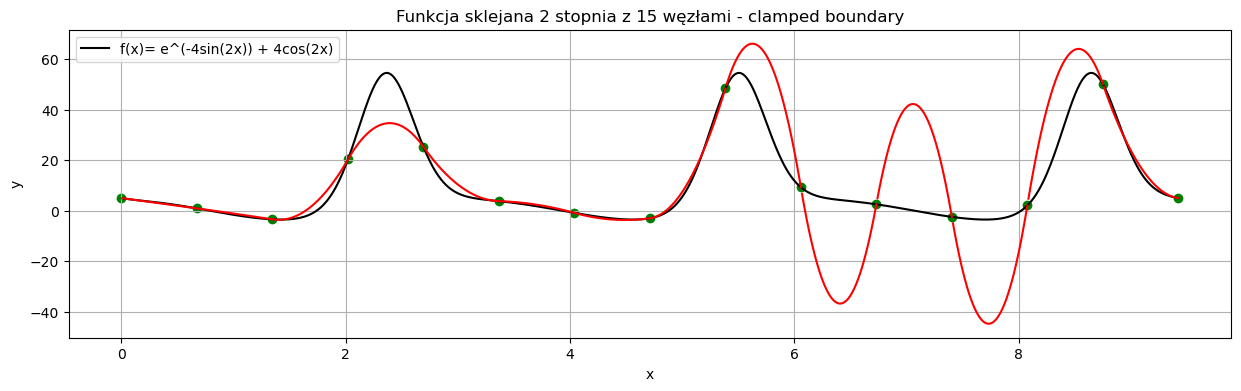

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               29.459186 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │            60439.855075 │
╘════════════════════════╧═════════════════════════╛


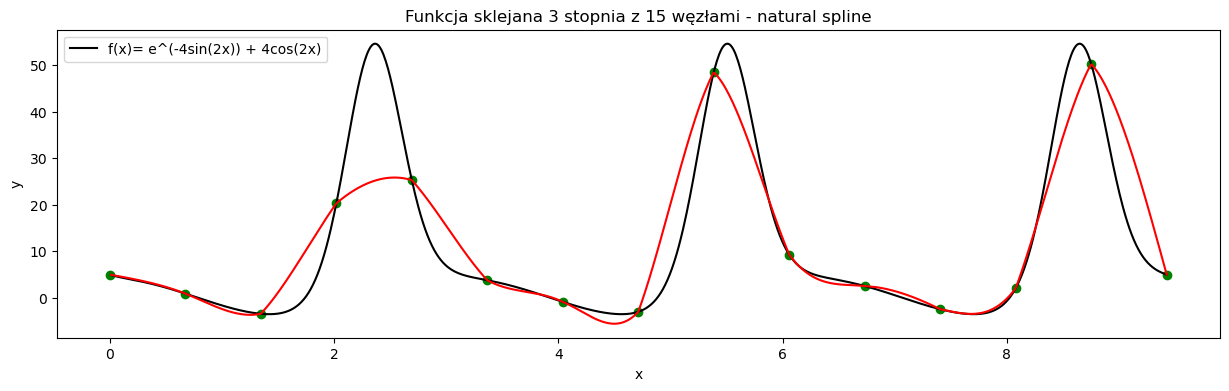

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              232.735887 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          4266415.172759 │
╘════════════════════════╧═════════════════════════╛


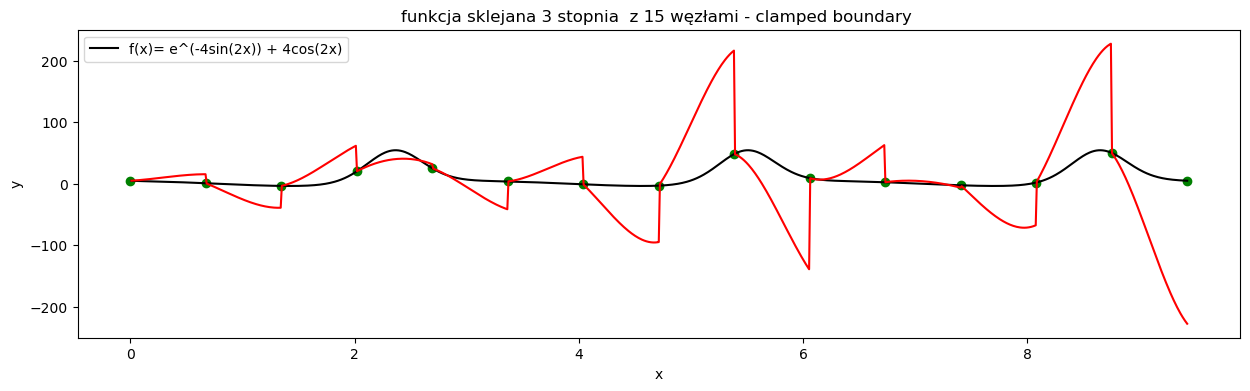

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               69.615542 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │         18453178.927895 │
╘════════════════════════╧═════════════════════════╛


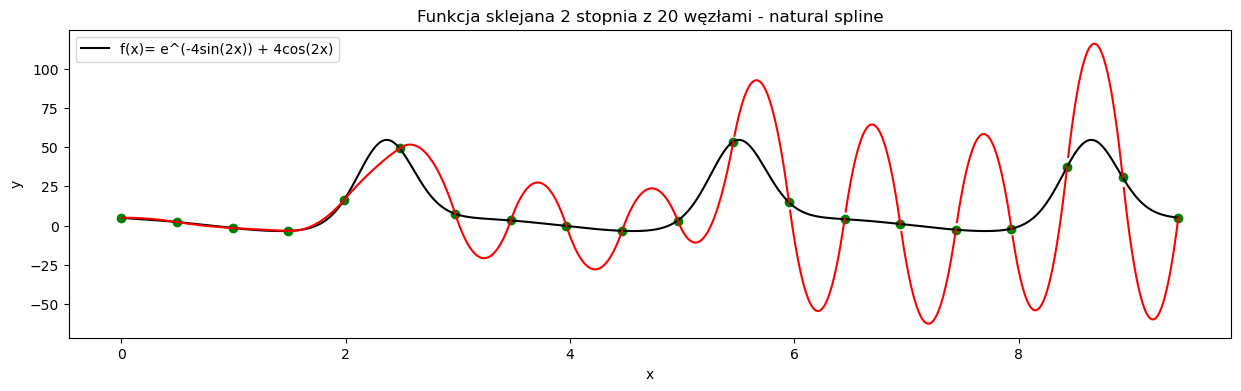

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               70.309654 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │         18946884.778374 │
╘════════════════════════╧═════════════════════════╛


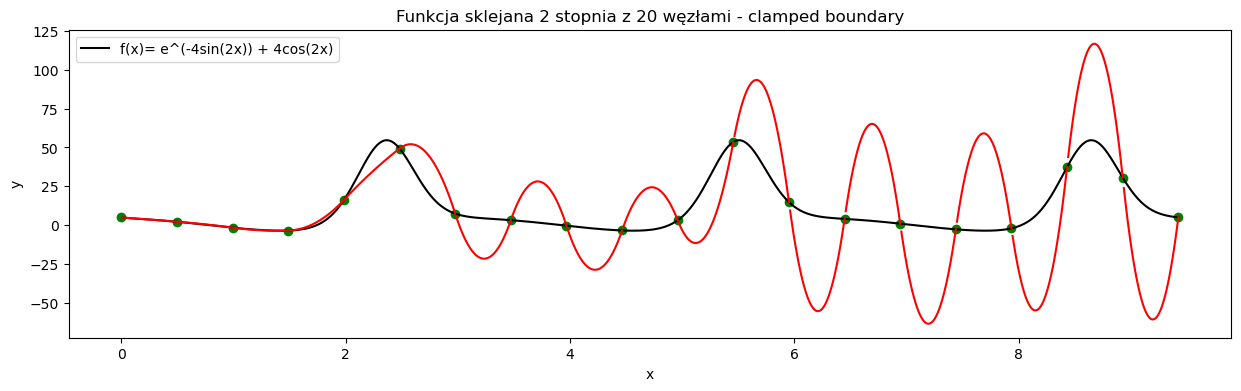

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               17.278250 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │            18625.226190 │
╘════════════════════════╧═════════════════════════╛


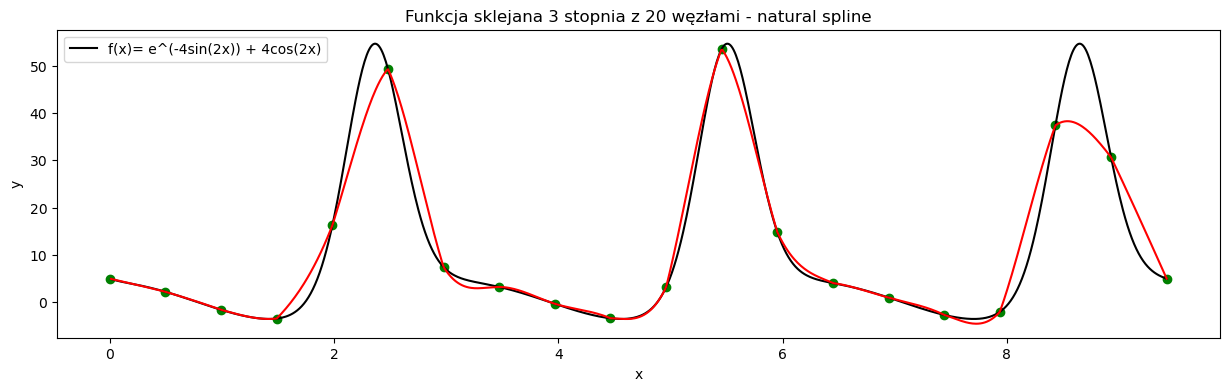

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              150.629248 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          1739347.804230 │
╘════════════════════════╧═════════════════════════╛


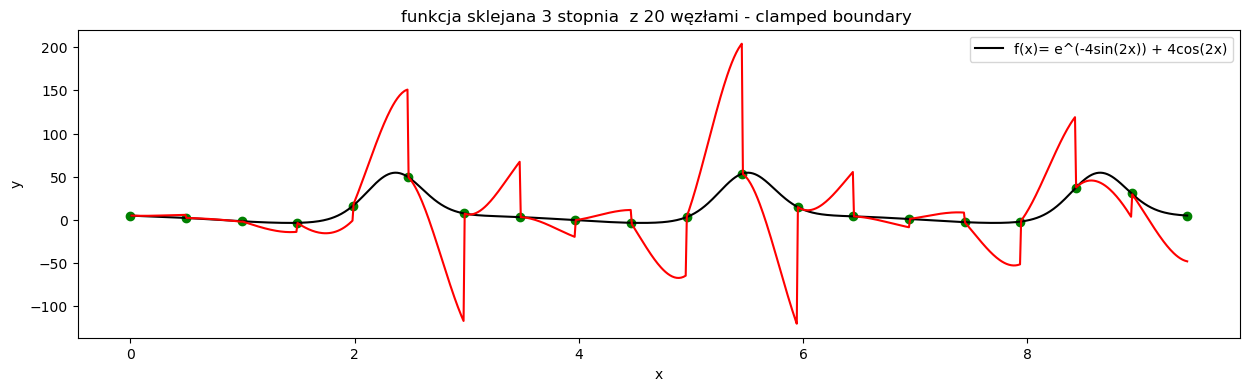

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               67.617993 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │         15818455.454884 │
╘════════════════════════╧═════════════════════════╛


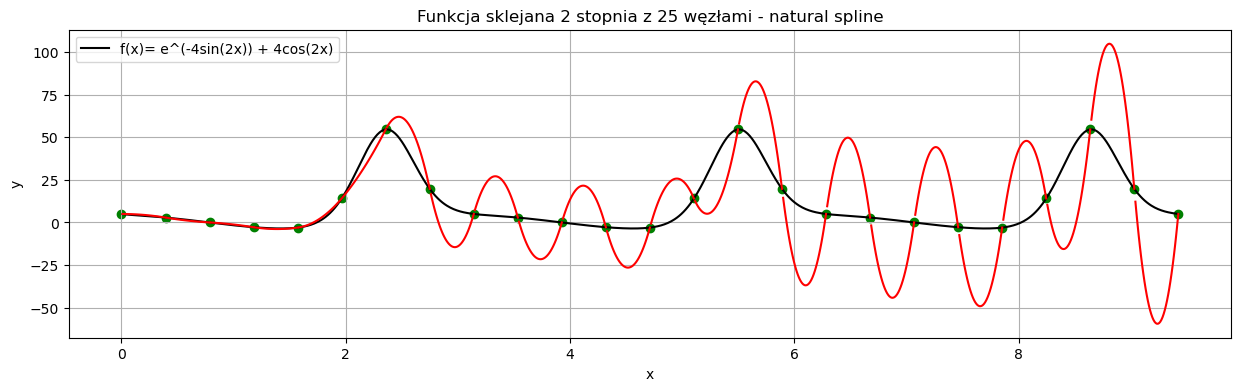

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               67.089919 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │         15433368.204937 │
╘════════════════════════╧═════════════════════════╛


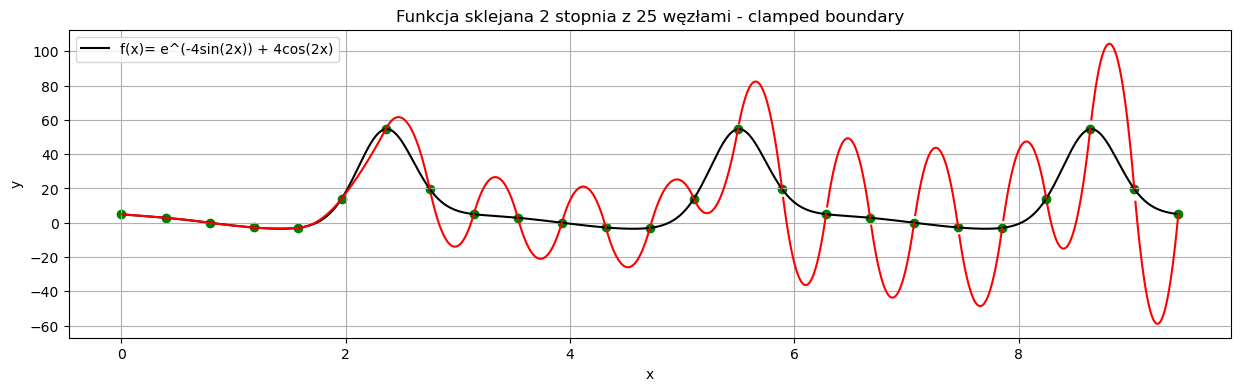

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                2.817216 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │             1311.931523 │
╘════════════════════════╧═════════════════════════╛


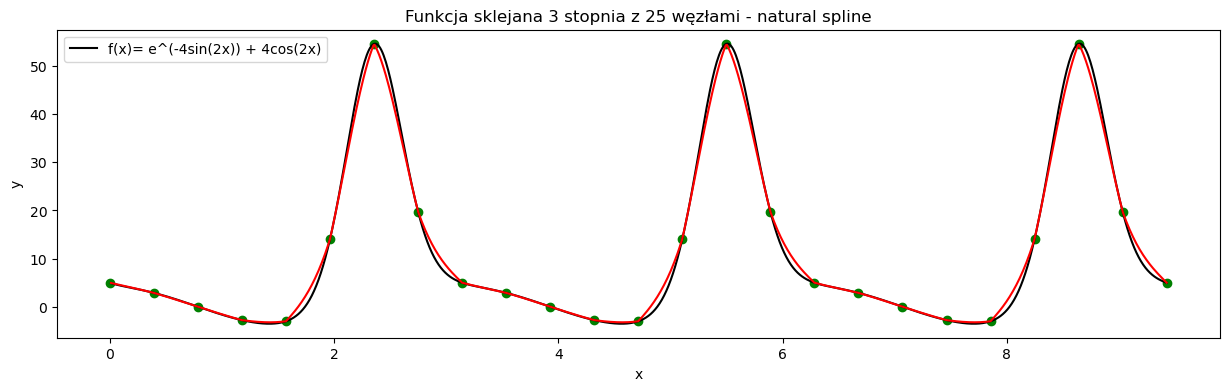

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │              107.869491 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          1105318.807780 │
╘════════════════════════╧═════════════════════════╛


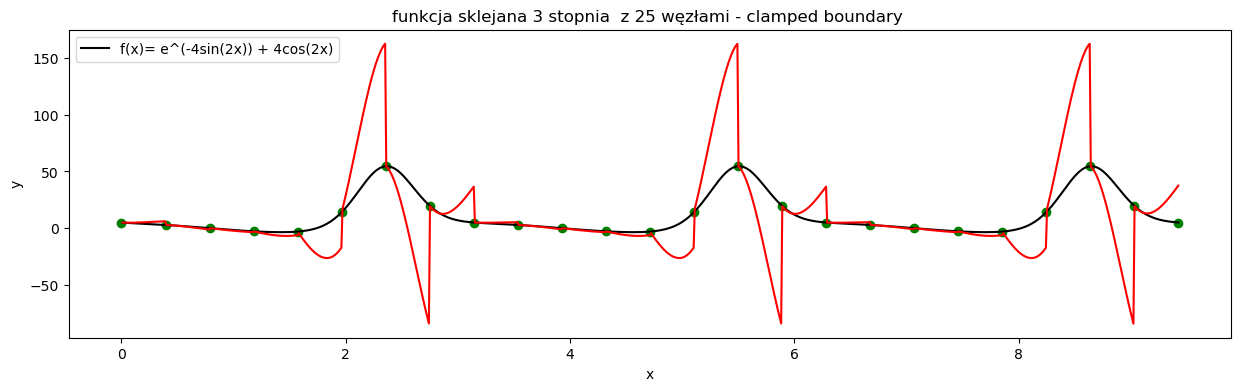

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               21.812927 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          2643959.305104 │
╘════════════════════════╧═════════════════════════╛


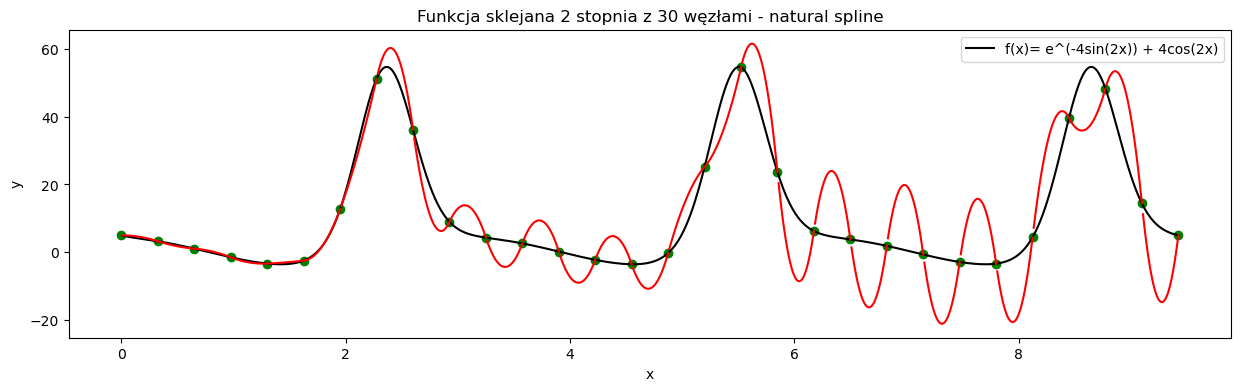

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               22.244494 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │          2788342.744603 │
╘════════════════════════╧═════════════════════════╛


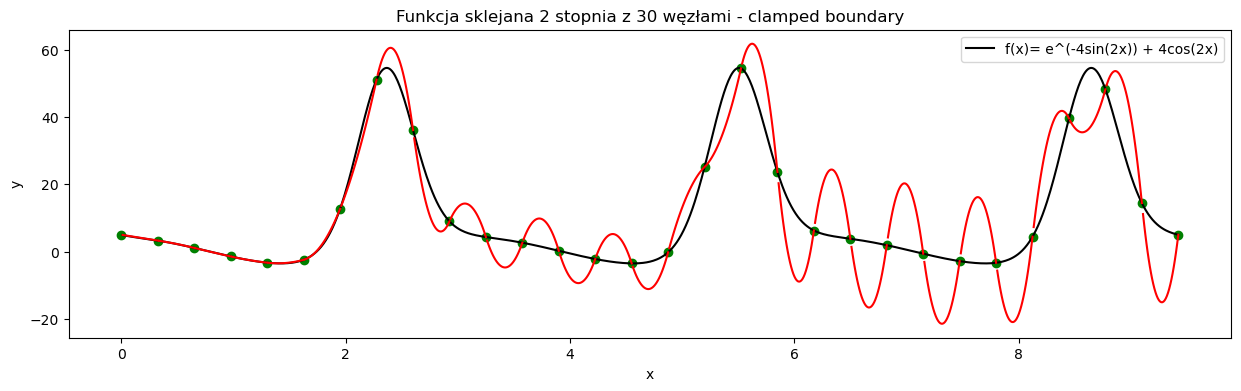

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                6.890484 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │             2397.689023 │
╘════════════════════════╧═════════════════════════╛


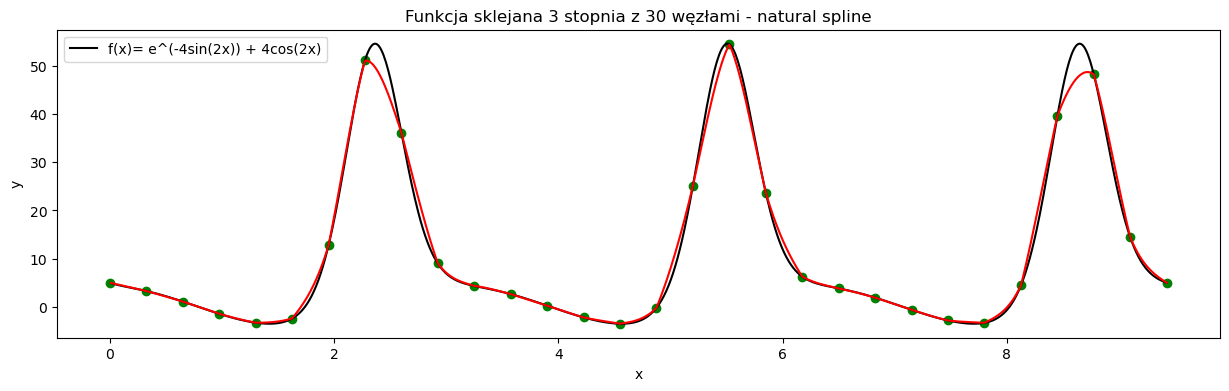

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               75.788111 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           343289.344393 │
╘════════════════════════╧═════════════════════════╛


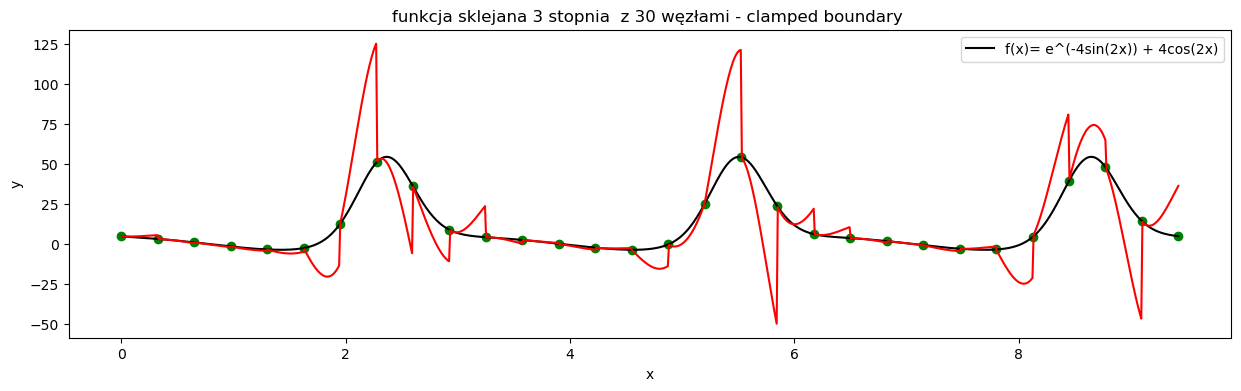

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                5.150751 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           147388.230023 │
╘════════════════════════╧═════════════════════════╛


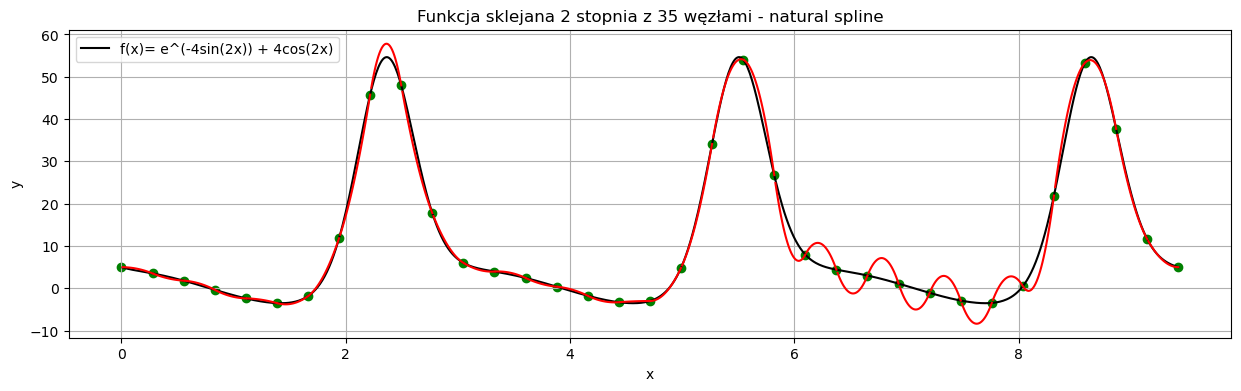

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                4.781541 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           124151.726062 │
╘════════════════════════╧═════════════════════════╛


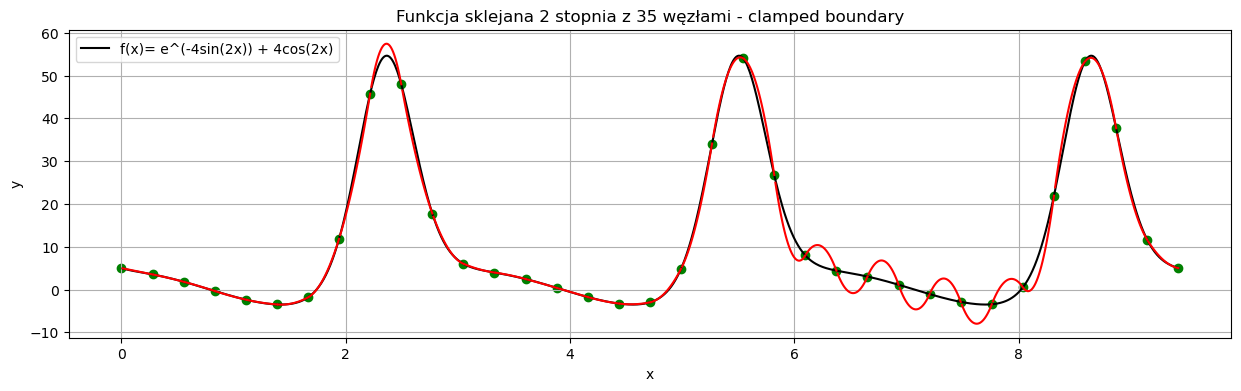

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                4.837767 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │             1113.528077 │
╘════════════════════════╧═════════════════════════╛


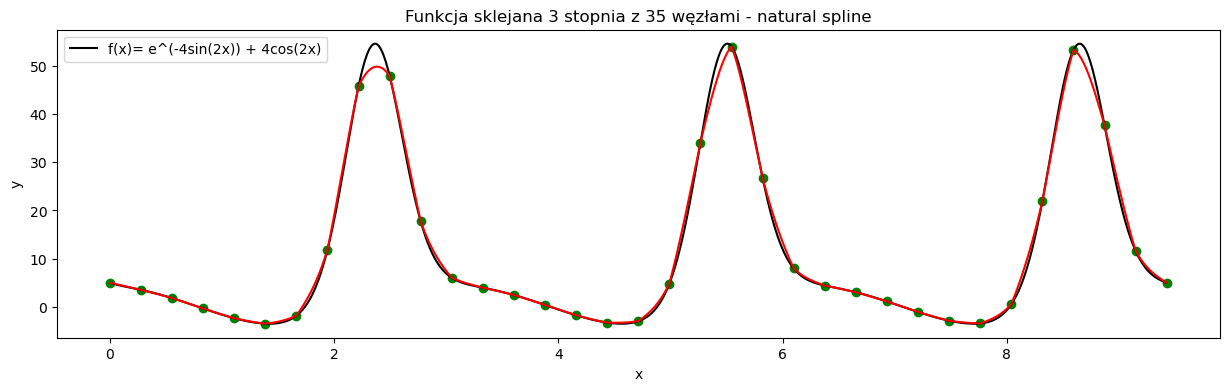

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               52.881898 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │           149575.313465 │
╘════════════════════════╧═════════════════════════╛


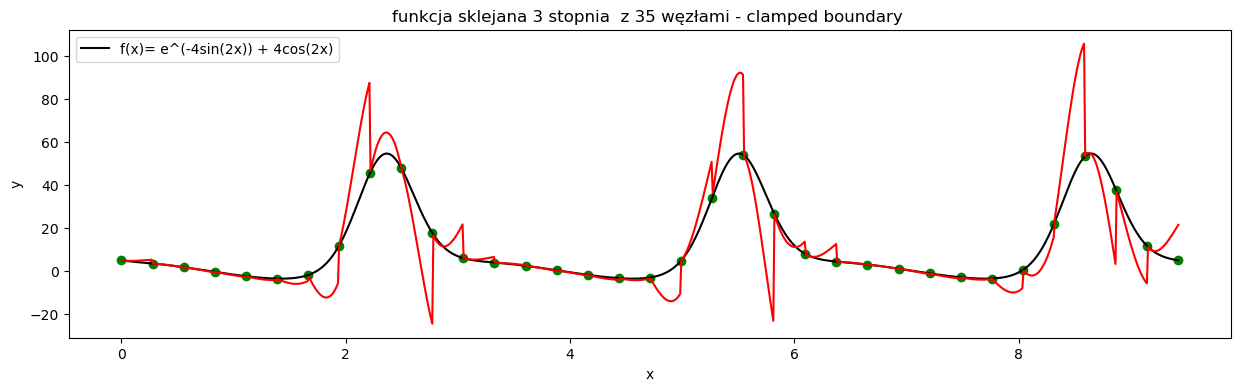

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                2.854483 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │            37290.616787 │
╘════════════════════════╧═════════════════════════╛


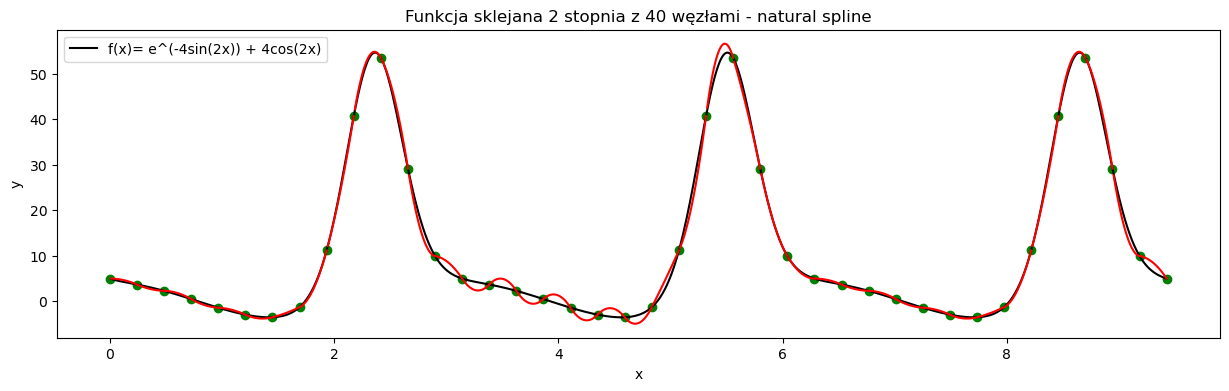

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                2.535759 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │            26949.374275 │
╘════════════════════════╧═════════════════════════╛


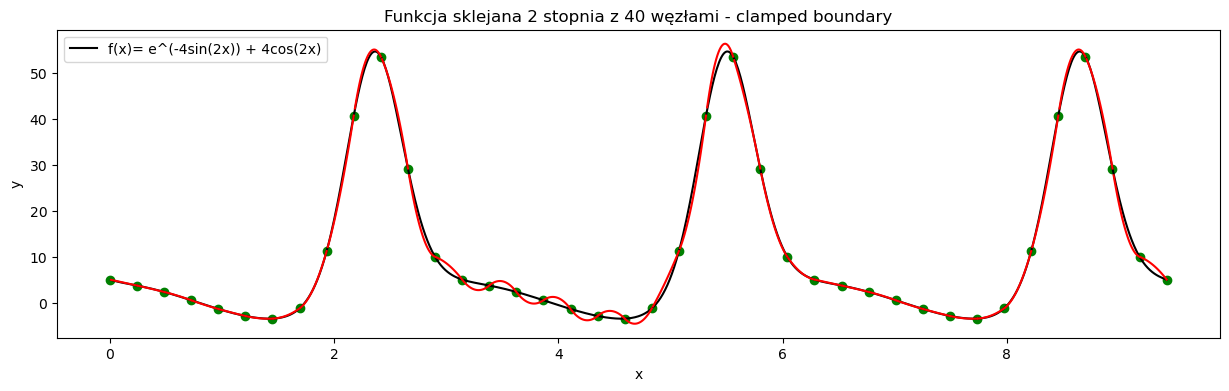

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                3.155468 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │              594.760433 │
╘════════════════════════╧═════════════════════════╛


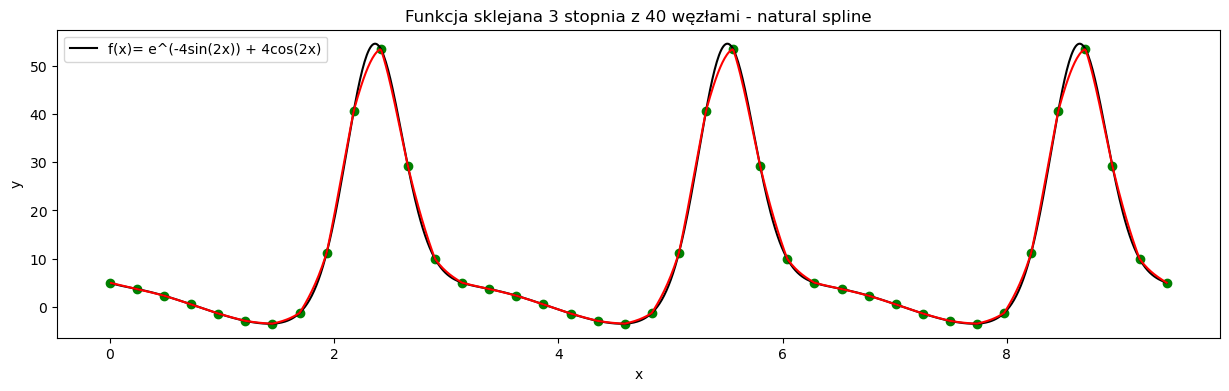

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               35.194449 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │            68168.616391 │
╘════════════════════════╧═════════════════════════╛


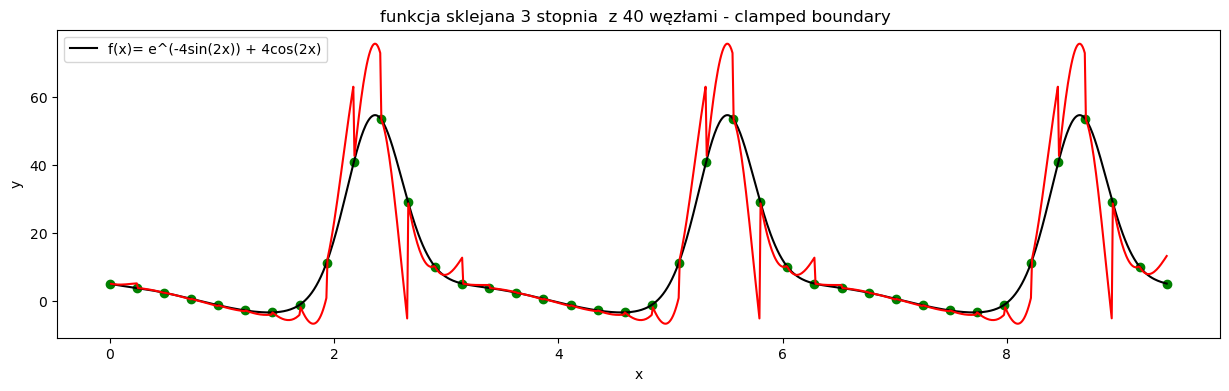

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                1.219777 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │             6776.445625 │
╘════════════════════════╧═════════════════════════╛


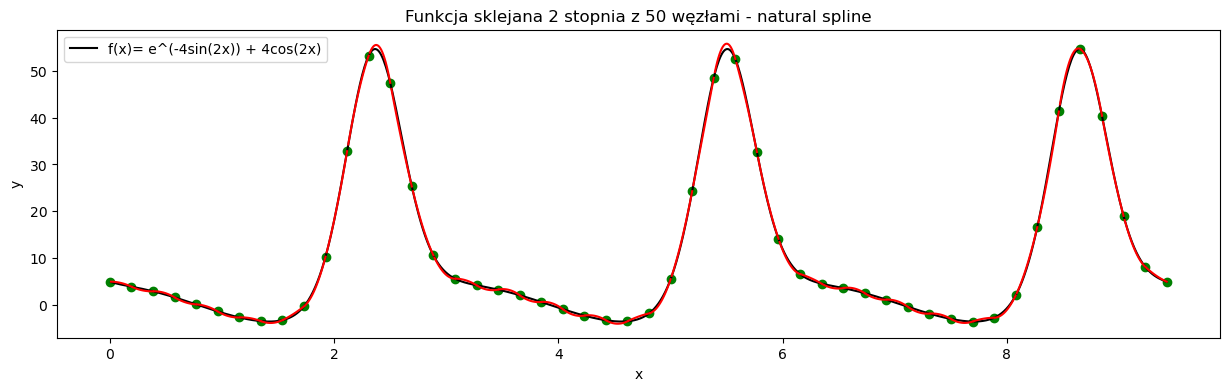

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                0.953316 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │             2533.115655 │
╘════════════════════════╧═════════════════════════╛


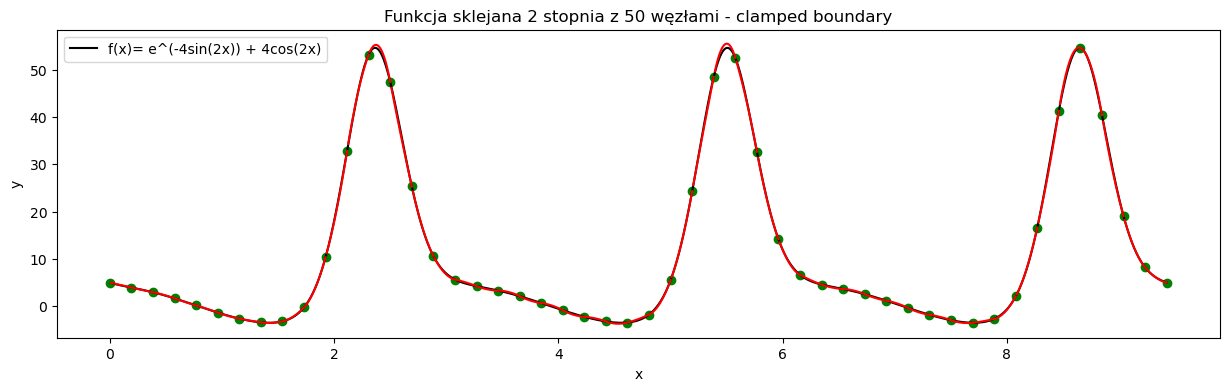

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                2.094314 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │              223.240898 │
╘════════════════════════╧═════════════════════════╛


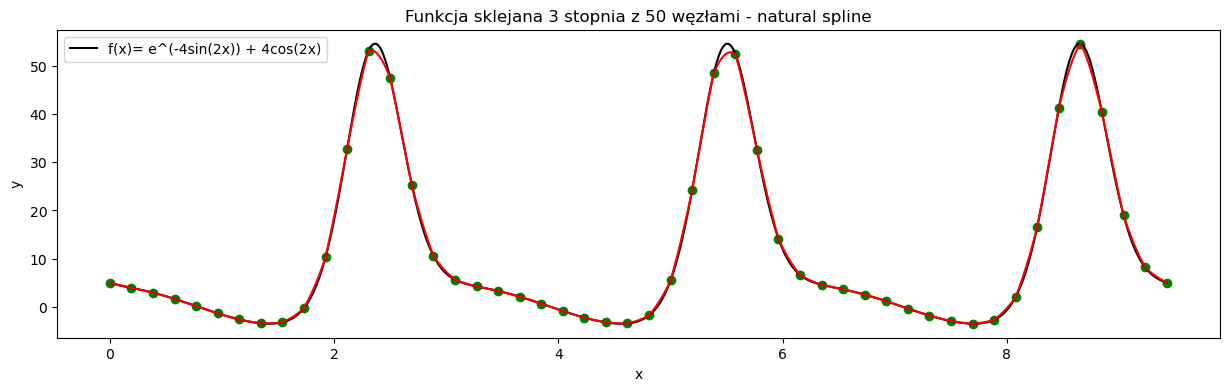

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │               18.401564 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │            18540.199012 │
╘════════════════════════╧═════════════════════════╛


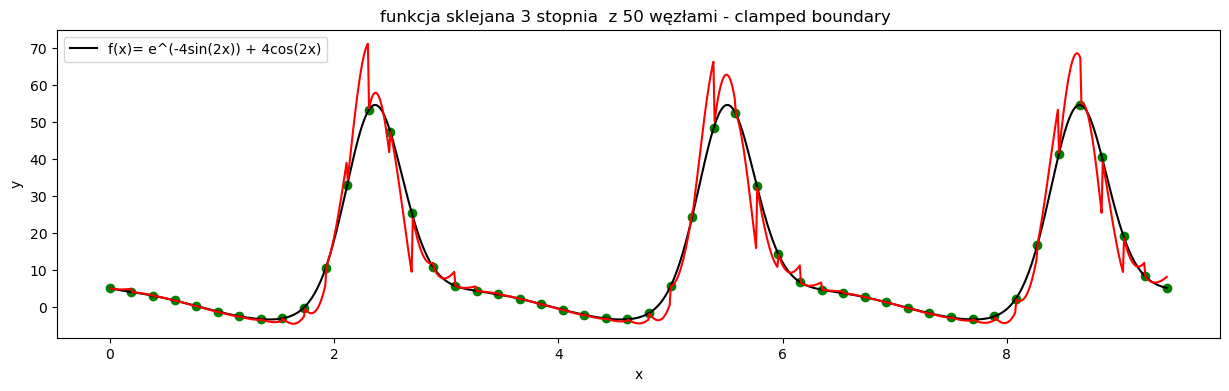

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                0.344378 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │             2252.912485 │
╘════════════════════════╧═════════════════════════╛


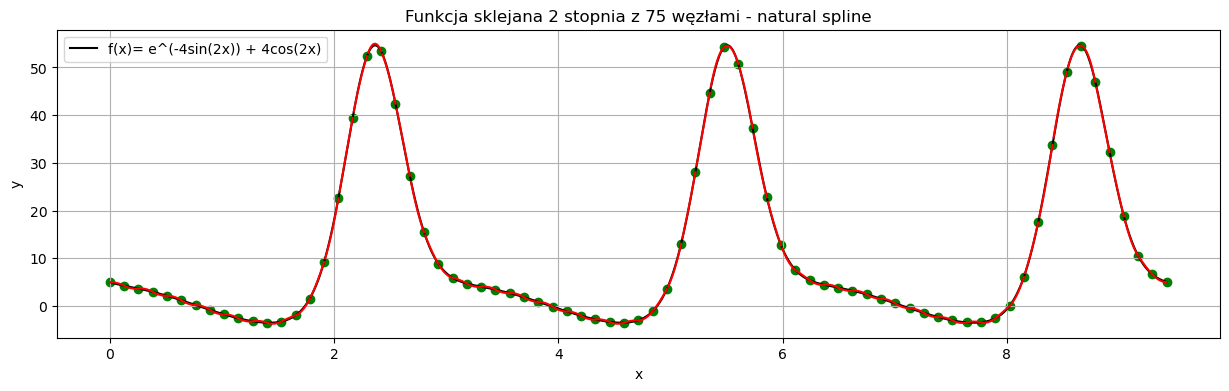

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                0.153359 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │              151.580653 │
╘════════════════════════╧═════════════════════════╛


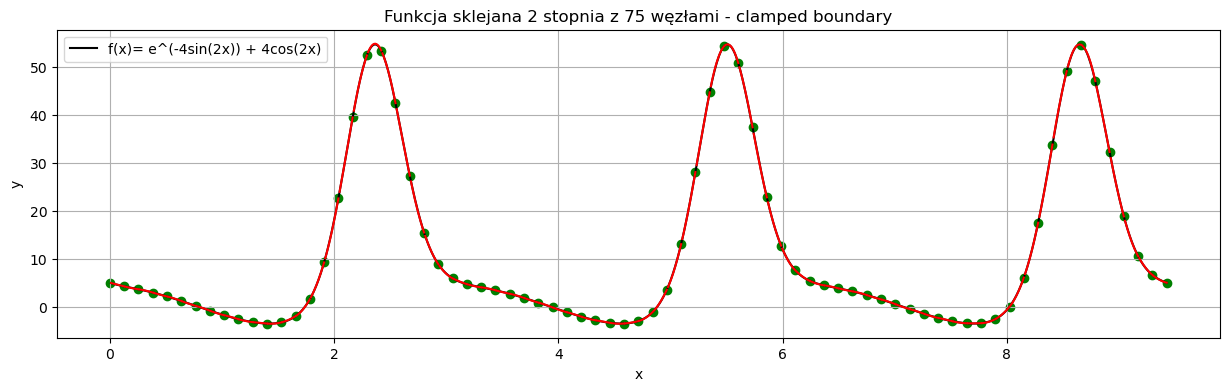

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                0.891524 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │               41.636089 │
╘════════════════════════╧═════════════════════════╛


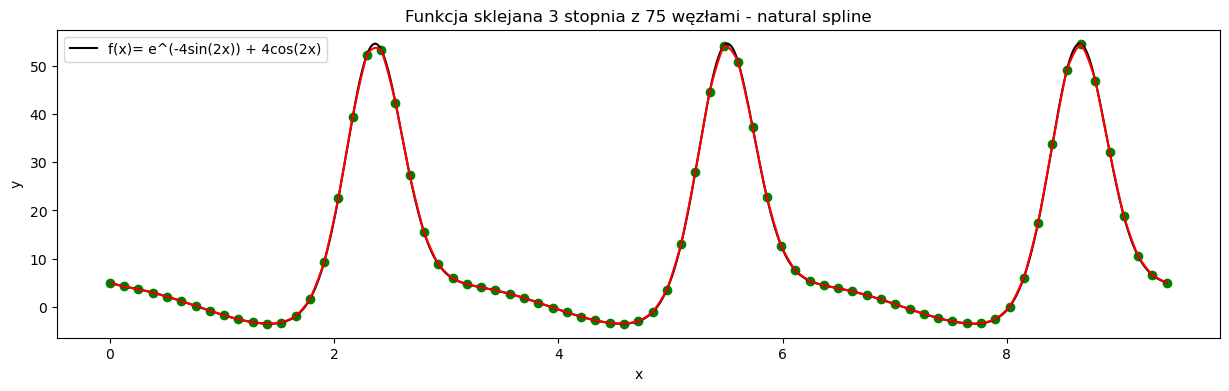

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                5.461494 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │             1923.394302 │
╘════════════════════════╧═════════════════════════╛


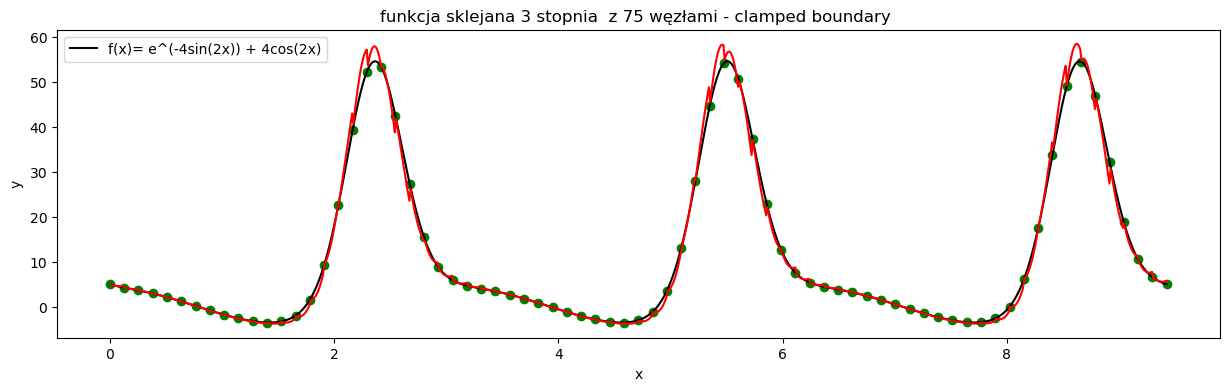

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                0.213121 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │             1760.120398 │
╘════════════════════════╧═════════════════════════╛


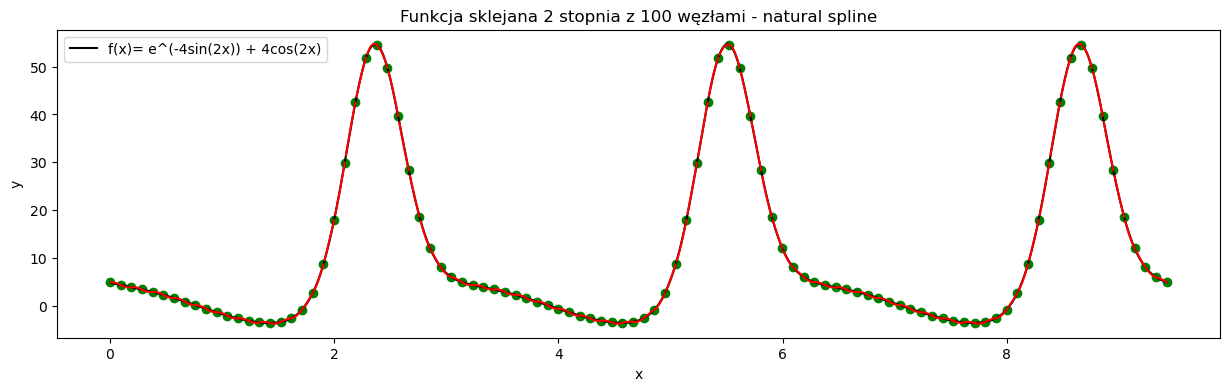

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                0.065620 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │               63.941169 │
╘════════════════════════╧═════════════════════════╛


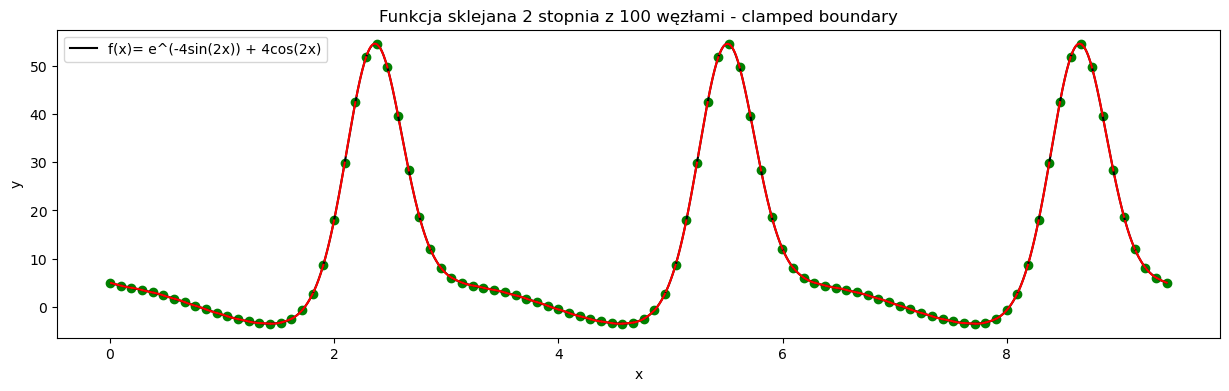

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                0.486820 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │               12.958094 │
╘════════════════════════╧═════════════════════════╛


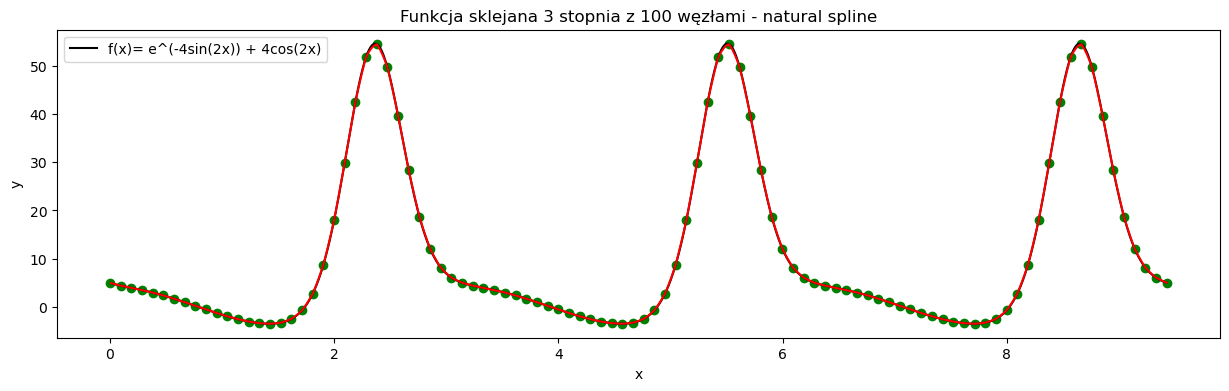

╒════════════════════════╤═════════════════════════╕
│                        │   Interpolacja Sklejana │
╞════════════════════════╪═════════════════════════╡
│ Błąd bezwzględny:      │                2.498353 │
├────────────────────────┼─────────────────────────┤
│ Suma kwadratów róznic: │              419.320553 │
╘════════════════════════╧═════════════════════════╛


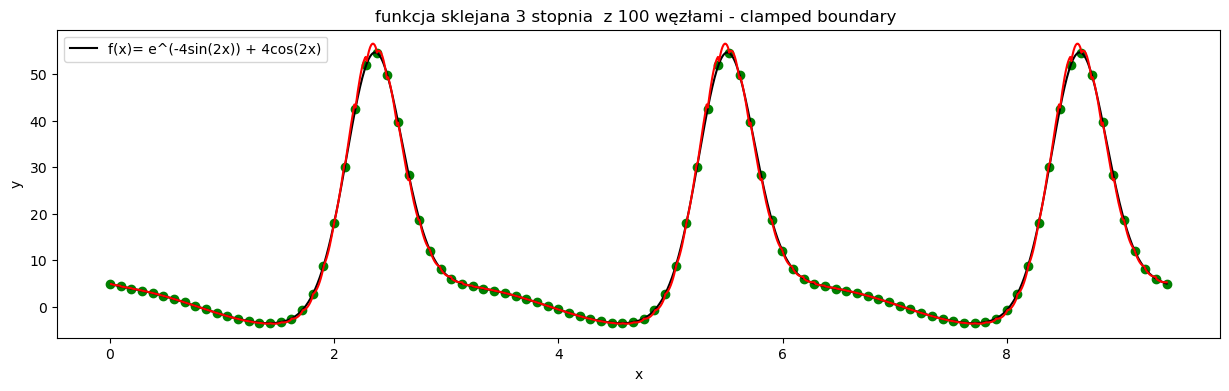

In [ ]:
tests = [3,5,7,10,12,13,15,20,25,30,35,40,50,75,100]


def test_splines(n):
    x = np.linspace(a, b, n)
    y = np.array([g(xi) for xi in x])

    plot_interpolation(g, n, spline_fun=quad_spline, title=f"Funkcja sklejana 2 stopnia z {n} węzłami - natural spline", show_err=True)
    plot_interpolation(g, n, spline_fun=quad_spline_clamped_boundary, title=f"Funkcja sklejana 2 stopnia z {n} węzłami - clamped boundary", show_err=True)
    plot_interpolation(g, n, spline_fun=cubic_spline, title=f"Funkcja sklejana 3 stopnia z {n} węzłami - natural spline", show_err=True)
    plot_interpolation(g, n, spline_fun=cubic_spline_clamped_boundary, title=f"funkcja sklejana 3 stopnia  z {n} węzłami - clamped boundary ", show_err=True)



for i in tests:
    test_splines(i)
